https://arxiv.org/pdf/1610.02391.pdf

In [4]:
import urllib
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

### GradCAMの定義

In [13]:
class GradCAM():
    def __init__(self, net, target_layer, use_cuda):
        self.net = net.eval()
        self.target_layer = target_layer
        self.use_cuda = use_cuda
        self.feature_map = 0
        self.grad = 0
        
        if self.use_cuda:
            self.net = self.net.cuda()
        
        for name, module in self.net.named_modules():
            if name == target_layer:
                module.register_forward_hook(self.save_feature_map) # forward段階のもの
                module.register_backward_hook(self.save_grad) # backward段階のもの
    
    def save_feature_map(self, module, input, output):
        '''
        最終層の出力Feature Mapを記録する
        '''
        self.feature_map =  output.detach()
        
    def save_grad(self, module, grad_in, grad_out):
        '''
        最終層逆伝播時の勾配を記録する
        '''
        self.grad = grad_out[0].detach()
        
    def __call__(self, x, index=None):
        x = x.clone()
        if self.use_cuda:
            x = x.cuda()
        
        # 予測結果 (1, 10)
        output = self.net(x)

        if index == None:
            # 予測結果 (1, )
            index = np.argmax(output.cpu().data.numpy())
            
        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot)
        one_hot.requires_grad_() # 勾配計算を有効に
        if self.use_cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
        
        # 勾配の初期化
        self.net.zero_grad()
        
        # 予測値に対する勾配の計算
        one_hot.backward()
        
        
        # 特徴量マップ
        self.feature_map = self.feature_map.cpu().numpy()[0]
        
        # 勾配
        self.weights = np.mean(self.grad.cpu().numpy(), axis = (2, 3))[0, :]
        
        # 特徴量マップと重みをかける
        cam = np.sum(self.feature_map * self.weights[:, None, None], axis=0)
        # ReLU
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.size()[-1], x.size()[-2]))
        return cam, index

def show_cam_on_image(img, mask):
    '''
    元画像に特徴量マップを重ね合わせる
    '''
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

### 入力画像

In [6]:
class ImageTransform():
    def __init__(self,size=256, p=0.5,degrees=90):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(size),
                transforms.RandomHorizontalFlip(p=p),
                transforms.RandomVerticalFlip(p=p),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),         
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [7]:
df_train = pd.read_table('../data/COWC_train_list_64_class.txt',header=None,names=['file_name','count'],sep=' ')
df_test = pd.read_table('../data/COWC_test_list_64_class.txt',header=None,names=['file_name','count'],sep=' ')
df_train['city'] = df_train.file_name.apply(lambda x: x.split('/')[0])
df_test['city'] = df_test.file_name.apply(lambda x: x.split('/')[0])
df_train['flag'] = 0
df_test['flag'] = 1
df = pd.concat([df_train,df_test])
total=len(df)
df.head()

/home/okamoto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/okamoto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,file_name,count,city,flag
0,Columbus_CSUAV_AFRL/train/00.00032.01373.030.png,0,Columbus_CSUAV_AFRL,0
1,Columbus_CSUAV_AFRL/train/00.00034.02382.045.png,0,Columbus_CSUAV_AFRL,0
2,Columbus_CSUAV_AFRL/train/00.00060.01446.030.png,0,Columbus_CSUAV_AFRL,0
3,Columbus_CSUAV_AFRL/train/00.00071.01912.030.png,0,Columbus_CSUAV_AFRL,0
4,Columbus_CSUAV_AFRL/train/00.00071.01912.165.png,0,Columbus_CSUAV_AFRL,0


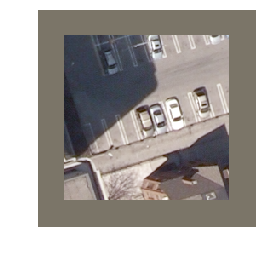

In [8]:
image_file_path = df.query('count==6 and flag==1')['file_name'].iloc[956]
image_file_path = '../data/' + image_file_path

transform = ImageTransform()
img = Image.open(image_file_path)
image = transform(img, phase='val').unsqueeze(0)

plt.imshow(img)
plt.axis('off')
plt.show()

### ネットワークの定義

In [9]:
use_pretrained = True

net = models.resnet50(pretrained=use_pretrained)

# 最後の層を付け替える
net.fc = nn.Linear(in_features=2048, out_features=10)

# #PyTorchのネットワークパラメータのロード
load_path = './weights/cowc_resnet_20.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### 予測

In [10]:
# softmax関数
softmax = nn.Softmax(dim=1)

def predict(net, img):
    '''
    予測結果を返す関数
    input
    - net : モデル
    - img : 予測する画像
    output
    - 予測結果 ex) 3
    '''
    img = img.convert('RGB')
    transform = ImageTransform()
    img_transformed = transform(img, phase='val')
    x = img_transformed.unsqueeze(0)
    pre_cnt = net(x)
    pre_cnt = torch.argmax(softmax(pre_cnt),dim=1)
    return pre_cnt.cpu().numpy()[0]

In [11]:
pre_cnt = predict(net, img)
print(pre_cnt)

5


### GradCam実行

In [14]:
# gradCAM
print("gradCAM...")
grad_cam = GradCAM(net, 'layer4.2', use_cuda=True)
cam, target_index = grad_cam(image)
cam_on_image = show_cam_on_image(np.array(img)/255, cam)
## 写真保存
#cv2.imwrite("./gradCAM_" + image_file_path.split('/')[-1], cam_on_image)

gradCAM...


(-0.5, 255.5, 255.5, -0.5)

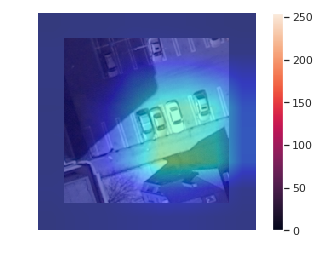

In [15]:
# 結果の表示
img_r = cv2.cvtColor(cam_on_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_r)
plt.colorbar()
plt.axis('off')

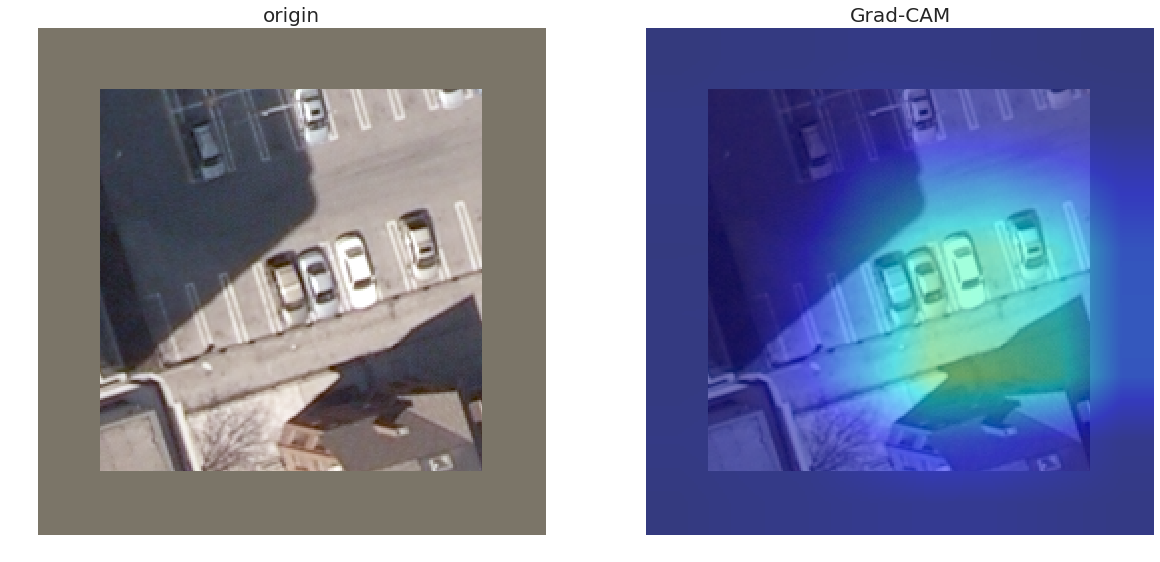

In [174]:
plt.figure(figsize=(20,15))
#plt.suptitle('Test Scene', fontsize=22)
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title('origin',fontsize=20)

plt.subplot(1,2,2)
plt.imshow(img_r)
plt.axis('off')
plt.title('Grad-CAM',fontsize=20)
plt.show()